In [2]:
import os
import sys
import json
import math
import numpy as np
from glob import glob
from PIL import Image
import nibabel as nib

import torch
from torch import nn
from torch.utils import data
import torch.multiprocessing as mp

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint


sys.path.insert(0, "../../cornucopia")
import cornucopia as cc

os.environ['PYTORCH_JIT_USE_NNC_NOT_NVFUSER'] = '1'
torch.set_float32_matmul_precision('medium')


/autofs/cluster/octdata2/users/epc28/miniconda/envs/vesselsynth/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/autofs/cluster/octdata2/users/epc28/miniconda/envs/vesselsynth/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:

oct_vol_path = "/cluster/octdata/users/cmagnain/190312_I46_SomatoSensory/I46_Somatosensory_20um_crop.nii"
label_path = "/cluster/octdata/users/cmagnain/190312_I46_SomatoSensory/Vessels_20um_crop_v4.nii"

class RealData(object):

    def __init__(self, path, label):
        self.label = label
        self.path = path
        self.nifti = nib.load(self.path)
        self.tensor = self.loadTensor(torch.float32)
        self.tensor1 = self.tensor
        self.affine = torch.tensor(self.nifti.affine)
        

    def loadTensor(self, dtype):
        if self.label == False:
            self.tensor = torch.tensor(self.nifti.get_fdata(), dtype=dtype)
            self.tensor = cc.QuantileTransform(pmin=0, pmax=1, vmin=0.05, vmax=0.95, clamp=False)(self.tensor)
            
        elif self.label == True:
            self.tensor = torch.tensor(self.nifti.get_fdata(), dtype=dtype)
            self.tensor[self.tensor <= 0] = 0
            self.tensor[self.tensor > 0] = 1
            #label.tensor.unique(return_counts=True)
        else:
            self.tensor = None

        return self.tensor


    def vis(self, tensor=None, slice=False):
        '''Example RealData(path).vis()'''

        if tensor == None:
            self.arr = self.tensor.numpy().astype(np.float32)
        else:
            self.arr = tensor.numpy().astype(np.float32)

        if slice == False:
            slice = self.arr.shape[0] // 2
        else:
            pass

        if self.label == False:
            arr = self.arr[slice] * 255
            img = Image.fromarray(arr.astype(np.uint8))
        elif self.label == True:
            arr = self.arr[slice] * 255
            img = Image.fromarray(arr.astype(np.uint8))
        else:
            pass
        return img
    
    #def augment(self):
        

oct = RealData(oct_vol_path, label=False)
label = RealData(label_path, label=True)

In [594]:
#oct.vis()
#label.vis()

In [4]:
import torchvision.transforms as T

class Augmentation(object):

    def __init__(self):
        self.flip = cc.RandomFlipTransform()
        self.gamma = cc.RandomGammaTransform((0.5, 2))
        self.rescale = cc.QuantileTransform(pmin=0, pmax=1, vmin=0.05, vmax=0.95, clamp=True)
        
        self.random_crop = T.RandomResizedCrop(256)
        self.perspective = T.RandomPerspective()

    
    def run(self, t1, t2):
        x = t1.tensor.clone()#.detach()
        y = t2.tensor.clone()#.detach()

        x = self.rescale(x)
        x = self.gamma(x)

        x, y = self.flip(x, y)
        both_images = torch.cat((x.unsqueeze(0), y.unsqueeze(0)), 0)
        
        ### BEGIN TRANSFORMING
        both_images = self.random_crop(both_images)
        both_images = self.perspective(both_images)
        both_images = T.ElasticTransform()(both_images)
        both_images = T.RandomRotation(180)(both_images)

        x = both_images[0]
        y = both_images[1]
        x = self.rescale(x)
        
        z_high = int(torch.randint(256, x.shape[0], [1]))
        z_low = z_high - 256

        x = x[z_low:z_high][:][:]

        return x, y


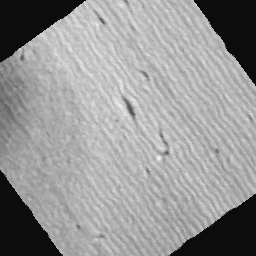

In [6]:
x, y = Augmentation().run(oct, label)

oct.vis(x)

In [7]:
x.unique()

tensor([0.0500, 0.0500, 0.0500,  ..., 0.9499, 0.9500, 0.9500])

In [10]:
affine = torch.tensor(oct.affine, dtype=torch.float64)

for i in range(500):
    print(i)
    x, y = Augmentation().run(oct, label)
    x = x.detach().cpu().numpy()
    y = y.detach().cpu().numpy()

    n = nib.Nifti1Image(x, affine=affine)
    nib.save(n, f"/autofs/cluster/octdata2/users/epc28/veritas/output/real_data/augmented/x_train/volume-{i:04d}.nii")

    n = nib.Nifti1Image(y, affine=affine)
    nib.save(n, f"/autofs/cluster/octdata2/users/epc28/veritas/output/real_data/augmented/y_train/volume-{i:04d}.nii")


/home/scratch/ipykernel_1821248/2329103839.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  affine = torch.tensor(oct.affine, dtype=torch.float64)


0


/autofs/cluster/octdata2/users/epc28/miniconda/envs/vesselsynth/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


KeyboardInterrupt: 

In [474]:
import torch
import torchvision.transforms as T

# Create two fake images (identical for test purposes):
image = oct.tensor
target = image.clone()

# This is the trick (concatenate the images):
both_images = torch.cat((image.unsqueeze(0), target.unsqueeze(0)), 0)

# Apply the transformations to both images simultaneously:
transformed_images = T.RandomResizedCrop(180)(both_images)

# Get the transformed images:
image_trans = transformed_images[0]
target_trans = transformed_images[1]

